In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
import shap
import random
import time
import warnings
warnings.filterwarnings('ignore')

In [33]:
# Load Dataset
df = pd.read_csv("C:/Users/awele/Documents/Machine Learning/processes2.csv")

# Data Cleaning and Preprocessing
df.drop(columns=['Unnamed: 0'], inplace=True)
df.columns = [
    'name', 'year', 'selling_price', 'km_driven', 'fuel', 'seller_type',
    'transmission', 'owner', 'seats', 'max_power_bph', 
    'mileage_unit', 'mileage', 'engine_cc'
]
df.dropna(inplace=True)
df = df[df['selling_price'] > 0]



fuel
Diesel    1075
Petrol    1000
CNG         19
LPG          1
Name: count, dtype: int64
seller_type
Individual          1919
Dealer               169
Trustmark Dealer       7
Name: count, dtype: int64
transmission
Manual       1996
Automatic      99
Name: count, dtype: int64
owner
First Owner             1325
Second Owner             586
Third Owner              146
Fourth & Above Owner      37
Test Drive Car             1
Name: count, dtype: int64


<Axes: xlabel='fuel', ylabel='count'>

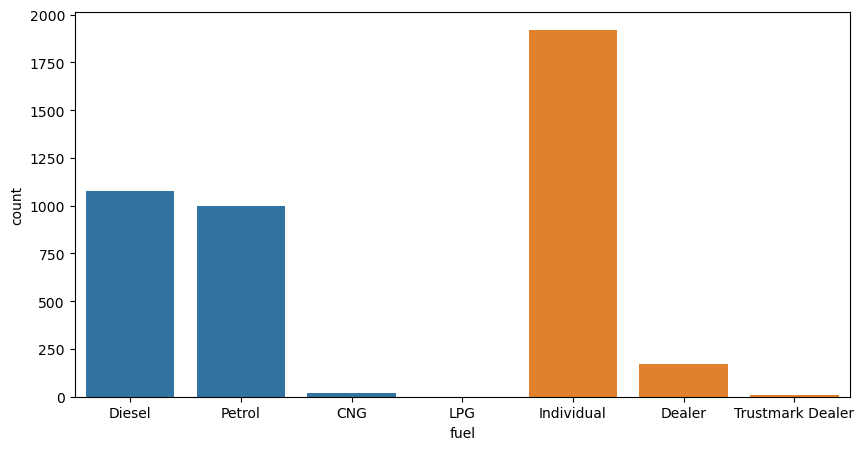

In [43]:
# Check distribution of categorical features
print(df['fuel'].value_counts())
print(df['seller_type'].value_counts())
print(df['transmission'].value_counts())
print(df['owner'].value_counts())

# Visualize the distributions
plt.figure(figsize=(10, 5))  
sns.countplot(x='fuel', data=df)
sns.countplot(x='seller_type', data=df)


0.8642114911351262
1.0023604805301216


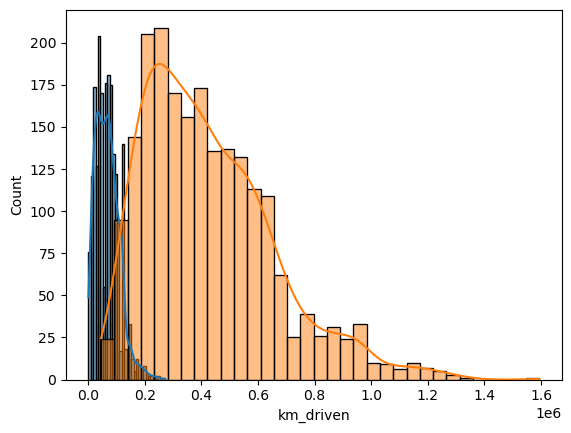

In [6]:
# Visualizing the distribution of numerical features
sns.histplot(df['km_driven'], kde=True)
sns.histplot(df['selling_price'], kde=True)

# Check for skewness
print(df['km_driven'].skew())
print(df['selling_price'].skew())


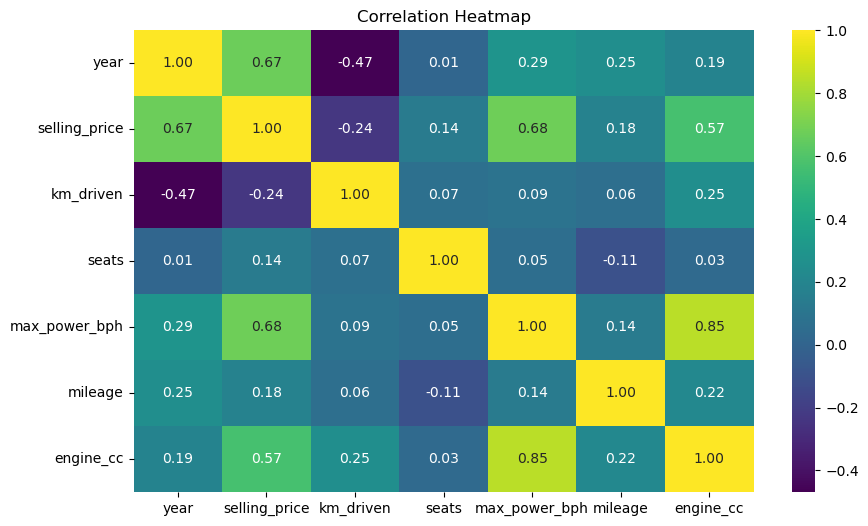

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

# Get correlation matrix
corr_matrix = df.corr(numeric_only=True)

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='viridis', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


In [9]:
# Convert categorical features to numeric
df = pd.get_dummies(df, columns=['fuel', 'seller_type', 'transmission', 'owner','mileage_unit'], drop_first=True)

df['car_age'] = 2025 - df['year']
df.drop(['year', 'name'], axis=1, inplace=True)

# Define X and y
X = df.drop('selling_price', axis=1)
y = df['selling_price']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [58]:
# Define base models
models = {
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'Linear Regression': LinearRegression(),
    'SVR': SVR()
}

# Function to evaluate models
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mse, r2
    
for name, model in models.items():
    mse, r2 = evaluate_model(model, X_train, X_test, y_train, y_test)
    print(f"{name} - MSE: {mse:.2f}, R²: {r2:.4f}")



Random Forest - MSE: 4920944859.17, R²: 0.8959
Gradient Boosting - MSE: 4961681479.86, R²: 0.8950
Linear Regression - MSE: 11492886052.53, R²: 0.7569
SVR - MSE: 47285294008.71, R²: -0.0003


In [66]:
from sklearn.model_selection import cross_val_score

print("\nCross-Validation Results:")
for name, model in models.items():
    # Negative MSE because sklearn returns negative values for loss metrics
    neg_mse_scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=5)
    r2_scores = cross_val_score(model, X, y, scoring='r2', cv=5)
    
    print(f"{name} - Mean CV MSE: {-neg_mse_scores.mean():.2f}, Mean CV R²: {r2_scores.mean():.4f}")



Cross-Validation Results:
Random Forest - Mean CV MSE: 5905397088.43, Mean CV R²: 0.8899
Gradient Boosting - Mean CV MSE: 6147688766.48, Mean CV R²: 0.8856
Linear Regression - Mean CV MSE: 14033002949.61, Mean CV R²: 0.7396
SVR - Mean CV MSE: 55901972426.85, Mean CV R²: -0.0344


In [13]:
# Experiment 1: Feature Scaling
print("\nExperiment 1: Feature Scaling")

# 1.1 Standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 1.2 Normalization
scaler_minmax = MinMaxScaler()
X_train_minmax = scaler_minmax.fit_transform(X_train)
X_test_minmax = scaler_minmax.transform(X_test)

# 1.3 Log Transformation (for skewed features, )
X_train_log = X_train.copy()
X_test_log = X_test.copy()
X_train_log['km_driven'] = np.log1p(X_train_log['km_driven'])
X_test_log['km_driven'] = np.log1p(X_test_log['km_driven'])

# Evaluate models with different scalings
scalers = ['StandardScaler', 'MinMaxScaler', 'Log Transformation']
for scaler_name, X_tr, X_te in zip(scalers, [X_train_scaled, X_train_minmax, X_train_log], [X_test_scaled, X_test_minmax, X_test_log]):
    print(f"\nEvaluating with {scaler_name}:")
    for model_name, model in models.items():
        mse, r2 = evaluate_model(model, X_tr, X_te, y_train, y_test)
        print(f"{model_name} - MSE: {mse:.4f}, R2: {r2:.4f}")


Experiment 1: Feature Scaling

Evaluating with StandardScaler:
Random Forest - MSE: 4885062521.5222, R2: 0.8967
Gradient Boosting - MSE: 4965176081.8969, R2: 0.8950
Linear Regression - MSE: 11492886052.5336, R2: 0.7569
SVR - MSE: 47261287251.3493, R2: 0.0002

Evaluating with MinMaxScaler:
Random Forest - MSE: 5037295770.6982, R2: 0.8934
Gradient Boosting - MSE: 4958222935.4542, R2: 0.8951
Linear Regression - MSE: 11492886052.5336, R2: 0.7569
SVR - MSE: 47265752436.6707, R2: 0.0001

Evaluating with Log Transformation:
Random Forest - MSE: 4889541810.3041, R2: 0.8966
Gradient Boosting - MSE: 4940710659.4670, R2: 0.8955
Linear Regression - MSE: 11671162724.8544, R2: 0.7531
SVR - MSE: 47276364115.2124, R2: -0.0001


In [14]:
# Experiment 2: Feature Engineering
print("\nExperiment 2: Feature Engineering")

# Polynomial Features
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Evaluate models with Polynomial Features
print("\nEvaluating with Polynomial Features:")
for model_name, model in models.items():
    mse, r2 = evaluate_model(model, X_train_poly, X_test_poly, y_train, y_test)
    print(f"{model_name} - MSE: {mse:.4f}, R2: {r2:.4f}")


Experiment 2: Feature Engineering

Evaluating with Polynomial Features:
Random Forest - MSE: 4935924329.8986, R2: 0.8956
Gradient Boosting - MSE: 4857613963.9511, R2: 0.8972
Linear Regression - MSE: 7253827897.8539, R2: 0.8465
SVR - MSE: 47286543641.3397, R2: -0.0004


In [17]:
# Experiment 3: Feature Transformations
print("\nExperiment 3: Feature Transformations")

# PCA
pca = PCA(n_components=5)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Evaluate models with PCA
print("\nEvaluating with PCA:")
for model_name, model in models.items():
    mse, r2 = evaluate_model(model, X_train_pca, X_test_pca, y_train, y_test)
    print(f"{model_name} - MSE: {mse:.4f}, R2: {r2:.4f}")



Experiment 3: Feature Transformations

Evaluating with PCA:
Random Forest - MSE: 7146777040.0700, R2: 0.8488
Gradient Boosting - MSE: 6831463876.3190, R2: 0.8555
Linear Regression - MSE: 13431337582.3090, R2: 0.7159
SVR - MSE: 47283443422.0265, R2: -0.0003


In [19]:
# Experiment 4: Handling Noisy Features
print("\nExperiment 4: Handling Noisy Features")

# Add random continuous noise
X_train_noisy = X_train.copy()
X_test_noisy = X_test.copy()
X_train_noisy['random_continuous'] = np.random.uniform(0, 1, X_train.shape[0])
X_test_noisy['random_continuous'] = np.random.uniform(0, 1, X_test.shape[0])

# Add random discrete noise
X_train_noisy['random_discrete'] = np.random.choice(['Category_A', 'Category_B', 'Category_C'], size=X_train.shape[0])
X_test_noisy['random_discrete'] = np.random.choice(['Category_A', 'Category_B', 'Category_C'], size=X_test.shape[0])

# Convert categorical noise into dummy variables
X_train_noisy = pd.get_dummies(X_train_noisy, drop_first=True)
X_test_noisy = pd.get_dummies(X_test_noisy, drop_first=True)

# Evaluate models with noise
print("\nEvaluating with Noisy Features:")
for model_name, model in models.items():
    mse, r2 = evaluate_model(model, X_train_noisy, X_test_noisy, y_train, y_test)
    print(f"{model_name} - MSE: {mse:.4f}, R2: {r2:.4f}")



Experiment 4: Handling Noisy Features

Evaluating with Noisy Features:
Random Forest - MSE: 5160369619.7294, R2: 0.8908
Gradient Boosting - MSE: 4965877830.3673, R2: 0.8949
Linear Regression - MSE: 11481072512.8492, R2: 0.7571
SVR - MSE: 47285312009.4820, R2: -0.0003



Experiment 5: Model Interpretability


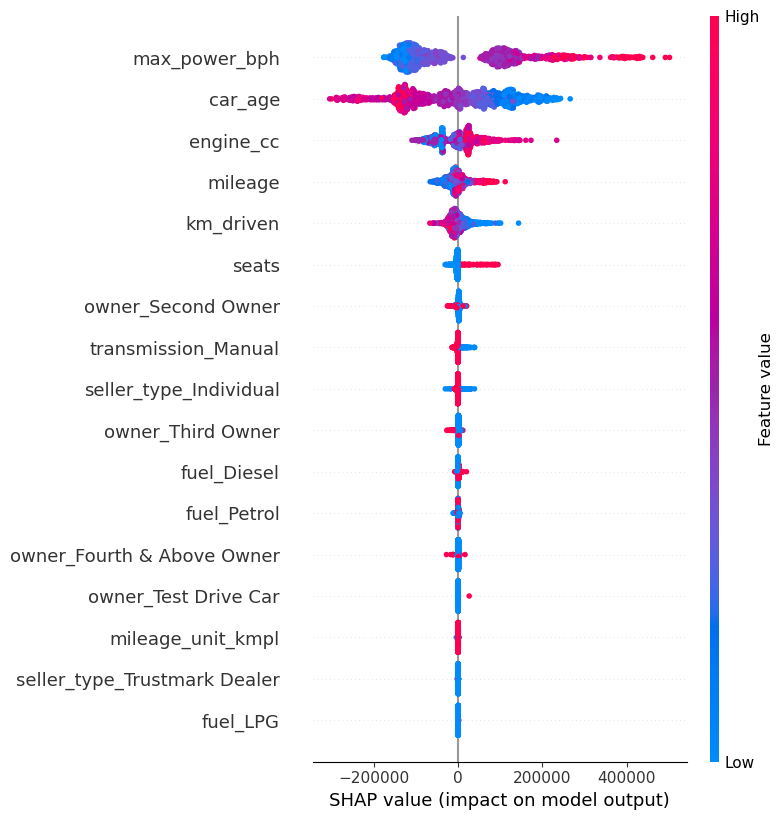

In [21]:
# Experiment 5: Model Interpretability using SHAP
print("\nExperiment 5: Model Interpretability")

# Train Random Forest as an example
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

# Calculate SHAP values
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_train)

# SHAP Summary Plot
shap.summary_plot(shap_values, X_train)

In [23]:
# Experiment 6: Model Efficiency and Deployment Readiness
print("\nExperiment 6: Model Efficiency and Deployment Readiness")

# Measure time for training and prediction for each model
for model_name, model in models.items():
    start_train = time.time()
    model.fit(X_train, y_train)
    end_train = time.time()
    training_time = end_train - start_train
    
    start_predict = time.time()
    y_pred = model.predict(X_test)
    end_predict = time.time()
    prediction_time = end_predict - start_predict
    
    print(f"\n{model_name} - Training Time: {training_time:.4f} sec, Prediction Time: {prediction_time:.4f} sec")


Experiment 6: Model Efficiency and Deployment Readiness

Random Forest - Training Time: 1.0027 sec, Prediction Time: 0.0253 sec

Gradient Boosting - Training Time: 0.3513 sec, Prediction Time: 0.0039 sec

Linear Regression - Training Time: 0.0056 sec, Prediction Time: 0.0020 sec

SVR - Training Time: 0.2960 sec, Prediction Time: 0.0954 sec


In [25]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingRegressor

# Experiment 7: Hyperparameter Tuning (Grid Search)
print("\nExperiment 7: Hyperparameter Tuning")

# Define hyperparameter grids for Random Forest and Gradient Boosting
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

param_grid_gb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
}

# Initialize the models
rf = RandomForestRegressor()
gb = GradientBoostingRegressor()

# Perform GridSearchCV on RandomForest
grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
grid_search_rf.fit(X_train, y_train)

# Perform GridSearchCV on GradientBoosting
grid_search_gb = GridSearchCV(gb, param_grid_gb, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
grid_search_gb.fit(X_train, y_train)

# Print best hyperparameters for both models
print("\nBest Hyperparameters for Random Forest:", grid_search_rf.best_params_)
print("\nBest Hyperparameters for Gradient Boosting:", grid_search_gb.best_params_)

# Evaluate the tuned models
best_rf = grid_search_rf.best_estimator_
best_gb = grid_search_gb.best_estimator_

mse_rf, r2_rf = evaluate_model(best_rf, X_train, X_test, y_train, y_test)
mse_gb, r2_gb = evaluate_model(best_gb, X_train, X_test, y_train, y_test)

print(f"\nRandom Forest (Tuned) - MSE: {mse_rf:.4f}, R2: {r2_rf:.4f}")
print(f"Gradient Boosting (Tuned) - MSE: {mse_gb:.4f}, R2: {r2_gb:.4f}")



Experiment 7: Hyperparameter Tuning
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Fitting 5 folds for each of 18 candidates, totalling 90 fits

Best Hyperparameters for Random Forest: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}

Best Hyperparameters for Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}

Random Forest (Tuned) - MSE: 4738438424.3535, R2: 0.8998
Gradient Boosting (Tuned) - MSE: 4423424930.1072, R2: 0.9064


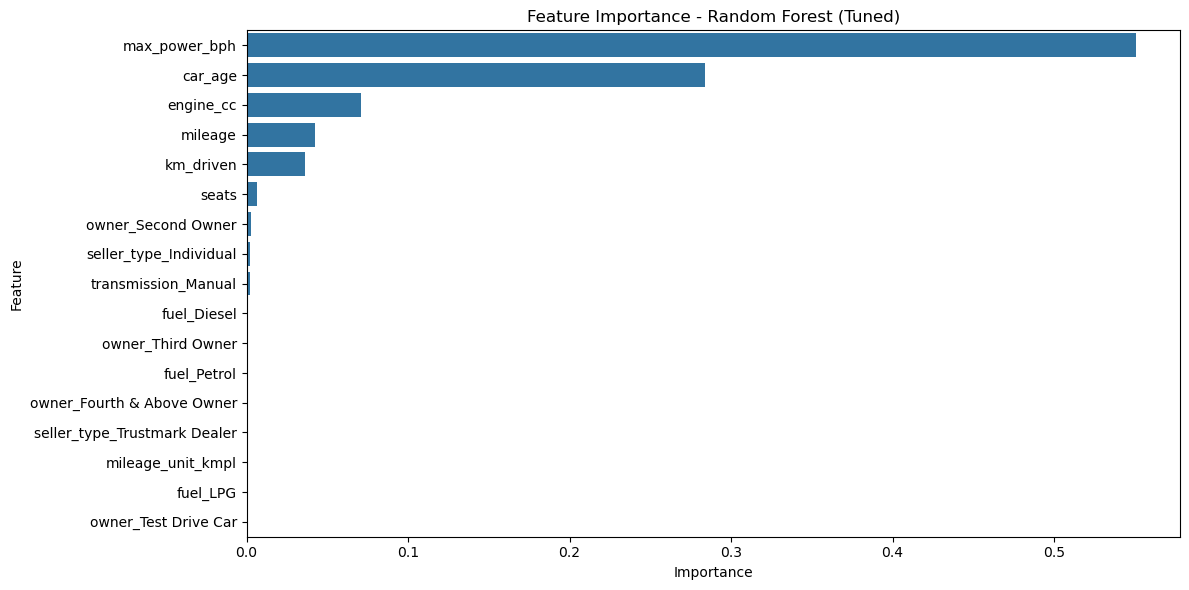

In [64]:
importances = best_rf.feature_importances_
features = X.columns
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)

plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance - Random Forest (Tuned)')
plt.tight_layout()
plt.show()
